# Import and Preprocess Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/new-mind/opinions.csv')

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Save splits to separate CSVs (optional)
# train_df.to_csv('train.csv', index=False)
# test_df.to_csv('test.csv', index=False)


In [ ]:
df.head()

,id,topic_id,text,type,effectiveness
0,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
1,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
2,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
3,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
4,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate


## Fix Class imbalance

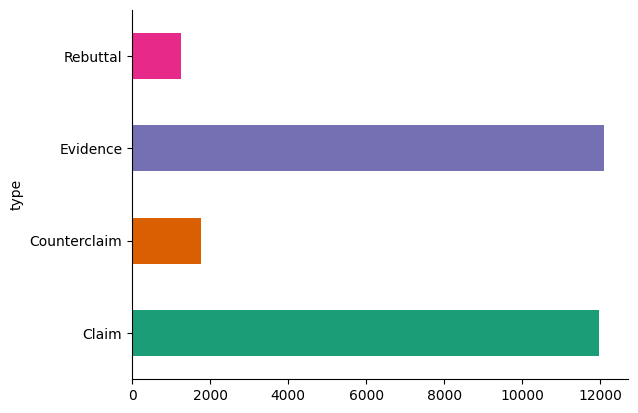

In [ ]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.groupby('type').size()

type
Claim           11977
Counterclaim     1773
Evidence        12105
Rebuttal         1244
dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['type'])
test_df['label'] = label_encoder.transform(test_df['type'])

# Oversample the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_df[['text']], train_df['label'])

# Create a new DataFrame with the resampled data
train_resampled_df = pd.DataFrame({'text': X_resampled['text'], 'label': y_resampled})
train_resampled_df['type'] = label_encoder.inverse_transform(train_resampled_df['label'])

In [ ]:
train_resampled_df.groupby('type').size()

type
Claim           9772
Counterclaim    9772
Evidence        9772
Rebuttal        9772
dtype: int64

In [ ]:
train_resampled_df.head()

,text,label,type
0,"Of course, most of us would have trouble actua...",0,Claim
1,this claim is unsupported as several important...,3,Rebuttal
2,"In addition to feeling like your vote matters,...",0,Claim
3,One little C could ruin any students chances o...,2,Evidence
4,"Cheating is never good, we learned that in sch...",2,Evidence


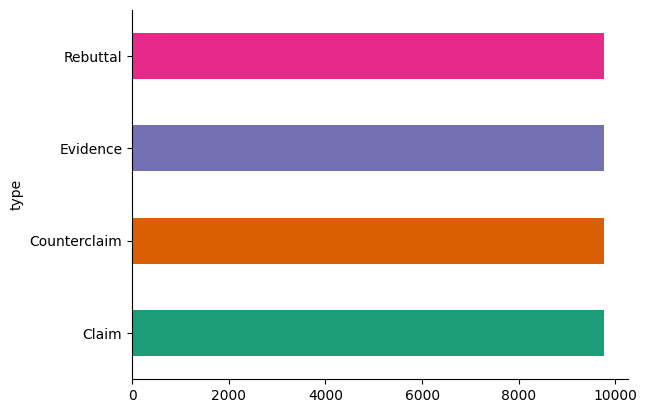

In [ ]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
train_resampled_df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
test_df.head()

,id,topic_id,text,type,effectiveness,label
3639,72eded3eaabe,5B66541ADDCD,When i joined the program it was hard definaty...,Claim,Adequate,0
22212,db9d9ddf9910,D8F3209E84CF,"The article mentioned ""many futurists believed...",Evidence,Adequate,2
10163,8d5a87ef1247,FB1553163CF5,"this shows and how dangerous it could be, but ...",Evidence,Ineffective,2
24069,ac6d047881d2,FBE13E9A446C,Defenders of the College may say that the poss...,Counterclaim,Effective,1
9331,a78426b8b3f9,E978E759F26B,"It also says in paragraph 6 that ""\n\nA classr...",Evidence,Adequate,2


In [ ]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding='max_length', max_length=128)

train_encodings = tokenizer(train_resampled_df['text'].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128)

train_labels = train_resampled_df['label'].tolist()
test_labels = test_df['label'].tolist()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)


In [ ]:
train_dataset[1]

{'input_ids': tensor([  101,  2023,  4366,  2003,  4895,  6342,  9397, 15613,  2004,  2195,
          2590,  2591,  4813,  2024,  2764,  2012,  1037,  2200,  2402,  2287,
          1010,  2429,  2000,  2195,  2913,  4953,  4167,  7264,  1012,  2083,
          3292,  4083,  1010,  1037,  3076,  2003, 16655,  2595, 19155,  2000,
          6695,  2005,  4975,  9897,  2591,  4813,  1010,  2029,  2024,  4072,
          2005,  2010,  2030,  2014,  3112,  1999,  1996,  2925,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./content/drive/MyDrive/new-mind/result',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train and evaluate
trainer.train()
metrics = trainer.evaluate()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.539700,0.621655,0.778413
2,0.335500,0.596048,0.795387
3,0.218600,0.634423,0.799815
4,0.192100,0.639000,0.796863
5,0.156700,0.650117,0.800369


In [ ]:
# Print accuracy
metrics

{'eval_loss': 0.5960483551025391,
 'eval_accuracy': 0.7953874538745388,
 'eval_runtime': 8.3858,
 'eval_samples_per_second': 646.335,
 'eval_steps_per_second': 5.128,
 'epoch': 5.0}

In [ ]:
model.save_pretrained('/content/drive/MyDrive/new-mind/bert_clf_ft')


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load saved model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/new-mind/bert_clf_ft')


In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = loaded_model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    predicted_label = label_encoder.inverse_transform([predicted_class_id])[0]
    return predicted_label

# Example usage
example_text = "This is an example sentence."
print(predict(example_text))


Claim


In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m